# How bikelanes along the street modify car crashes count

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Data loading

After loading data form `mainstreet.csv` contains the following columns:

-  `x` and `y`: longitude and latitude marking the middle point of a street.
-  `category`: 1 for avenues, 0 for streets.
-  `way`: 1 for two way streets, else 0.
-  `comerce`: number of businesses over the street.
-  `length`: street length in meters.
-  `comerce_ratio`: Number of businesses over 100 meters.
-  `bikelane`: Signals the presence of a bikelane.
-  `crash`: Number of car accidents reported.
-  `outcome`: Signals if at least one accident has occured on that street.

In [5]:
cols = ['x', 'y', 'category', 'way', 'comerce', 'length', 'comerce_ratio', 'bikelane', 'crash', 'geometry']
main = (pd.read_csv('./data/mainstreets.csv', usecols=cols)
            .loc[:, cols]
            .assign(nonzero = lambda df: df.crash.apply(lambda x: 1 if x>0 else 0),
                    comerce_ratio = lambda df: df.comerce_ratio.apply(lambda x: x * 100))
)

In [5]:
main = pd.read_csv('./data/mainstreets.csv')

In [9]:
main.loc[main.bikecat==1]

,name,category,bikecat,hood,bikelane,way,length,comerce,comerce_ratio,crash,geometry,x,y
8,14 DE JULIO,0,1,PATERNAL,1,0,198.840000,26,0.130758,1,MULTILINESTRING ((-58.4677386323956 -34.590769...,-58.467988,-34.590923
9,14 DE JULIO,0,1,PATERNAL,1,1,95.733834,12,0.125348,0,MULTILINESTRING ((-58.4696958481684 -34.591971...,-58.469277,-34.591714
238,ANDONAEGUI,0,1,SAAVEDRA,1,1,291.460000,13,0.044603,0,MULTILINESTRING ((-58.4990519301011 -34.564721...,-58.499917,-34.563620
495,BAUNESS,0,1,PARQUE CHAS,1,0,280.960000,20,0.071185,0,MULTILINESTRING ((-58.4740599509409 -34.590009...,-58.474991,-34.589004
496,BAUNESS,0,1,PATERNAL,1,1,157.550000,0,0.000000,0,MULTILINESTRING ((-58.473319373098 -34.5908087...,-58.473538,-34.590573
736,CABILDO,1,1,SAAVEDRA,1,1,7.420000,0,0.000000,1,LINESTRING (-58.4685090378691 -34.548540444319...,-58.468531,-34.548513
823,CAMPILLO,0,1,PARQUE CHAS,1,0,451.380000,53,0.117418,1,MULTILINESTRING ((-58.4788564875854 -34.590220...,-58.477739,-34.589367
863,CARACAS,0,1,AGRONOMIA,1,0,312.790000,33,0.105502,0,MULTILINESTRING ((-58.4888354073123 -34.589318...,-58.488483,-34.589706
1353,DE LOS CONSTITUYENTES,1,1,PARQUE CHAS,1,1,507.830000,27,0.053167,1,MULTILINESTRING ((-58.4795446410252 -34.590751...,-58.482143,-34.589986
1393,DEL CAMPO,1,1,PATERNAL,1,0,41.460000,0,0.000000,6,LINESTRING (-58.4665926113742 -34.590735040376...,-58.466775,-34.590625


In [6]:
main.head(3)

,x,y,category,way,comerce,length,comerce_ratio,bikelane,crash,geometry,nonzero
0,-58.448221,-34.562186,0,0,22,807.91,2.723076,0,0,MULTILINESTRING ((-58.4455213310398 -34.565340...,0
1,-58.460531,-34.546794,0,0,150,1398.32,10.727158,0,3,MULTILINESTRING ((-58.4564908820515 -34.552326...,1
2,-58.466130,-34.539181,0,1,101,695.38,14.524433,0,6,MULTILINESTRING ((-58.4641688401557 -34.541846...,1


## Exploratory data analysis

#### Number of streets w/wo crashes and crash count histogram

In [7]:
count_outcome = main.groupby('nonzero').size().to_frame('count').reset_index(drop=False)

In [8]:
gini_outcome = (main
                    .crash.sort_values(ascending=False).cumsum()
                    .to_frame().reset_index(drop=True)
                    .assign(percentage = lambda df: (np.arange(len(df)) / (len(df)-1)),
                            crash = lambda df: df.crash / df.crash.max())
)

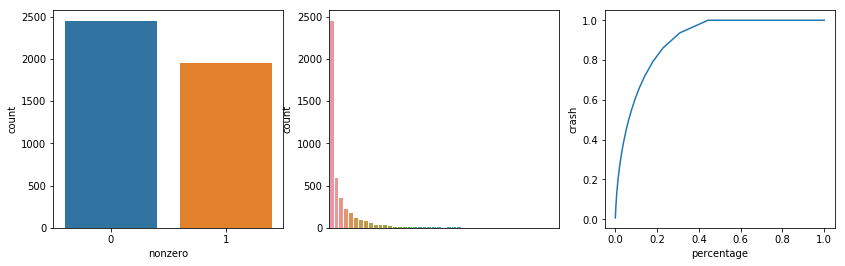

In [9]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
sns.barplot('nonzero', 'count', data=count_outcome, ax=ax[0])
sns.countplot('crash', data=main, ax=ax[1], )
sns.lineplot('percentage', 'crash', data=gini_outcome, ax=ax[2])
ax[1].set_xlabel('')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

The left figure shows that 55% of streets do not report any car accident during 2017. Figure on the middle is an histogram showing car accidents count distribution. Both figures show an elevated number of zero counts, likely due to the chance of a car accident not being evenly distributed across all streets. This is because the street population is highly heterogeneous. Left figure is a cumulative density plot of car accidents.

## Matching

For this, matched pairs study design was opted. For every street with a bikelane (cases) we matched it with a similar street without a bikelane. The matching algorithm used was nearest-neighbors using matching features as geographical position, street/avenue, business per 100 meters, length and one or two-way street.

In [10]:
cases = main.loc[(main.bikelane == 1)].drop(columns='bikelane')
controls = main.loc[(main.bikelane == 0)].drop(columns='bikelane')

In [13]:
matched = matching(
    cases,
    controls,
    features=['x', 'y', 'category', 'comerce_ratio', 'way', 'length'],
    outcome='crash',
    ratio=1
)

### Plotting matched dataset

In [14]:
count_outcome = matched.groupby('nonzero').size().to_frame('count').reset_index(drop=False)

In [43]:
gini_outcome = (matched
                    .outcome.sort_values(ascending=False).cumsum()
                    .to_frame().reset_index(drop=True)
                    .assign(percentage = (lambda df: (np.arange(len(df)) / (len(df)-1))),
                            outcome = lambda df: df.outcome / df.outcome.max())
)

gini_outcome.loc[:, 'outcome'] = pd.to_numeric(gini_outcome.outcome)

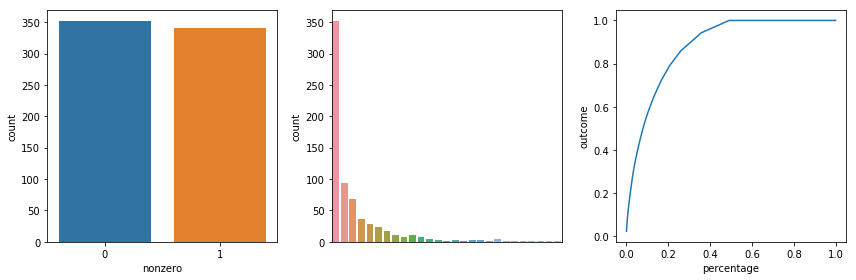

In [44]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot('nonzero', 'count', data=count_outcome, ax=ax[0])
sns.countplot('outcome', data=matched, ax=ax[1], )
sns.lineplot('percentage', 'outcome', data=gini_outcome, ax=ax[2])
ax[1].set_xlabel('')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tight_layout()
plt.savefig('./assets/figure1.png')
plt.show()

Above, the same data structure than before can be seen in the three figures. Next we save the matched dataframe so can be exported to R where a zero-inflated model will be fit.

In [45]:
matched.to_csv('./data/matched.csv', index=False)

## Modeling

Output of R function zeroinfl from pscl package. The R file can be seen in `./zero-inflated-model.Rmd`.

```
zeroinfl(
    outcome ~ exposed + length + way + category + comerce_ratio,
    data = matched,
    dist = "negbin"
)


Count model coefficients (negbin with log link):
                    Estimate StdErr     z    P exp(Est.) 2.5% 97.5%
count_(Intercept)      -0.10   0.19 -0.53 0.60      0.91 0.63  1.31
count_exposed1          0.14   0.12  1.11 0.27      1.15 0.90  1.45
count_length            0.00   0.00  9.89 0.00      1.00 1.00  1.00
count_way1             -0.02   0.20 -0.09 0.93      0.98 0.66  1.46
count_category1         0.62   0.18  3.53 0.00      1.86 1.32  2.62
count_comerce_ratio     0.03   0.01  2.43 0.01      1.03 1.01  1.06

Zero-inflation model coefficients (binomial with logit link):
                    Estimate StdErr     z    P exp(Est.) 2.5% 97.5%
zero_(Intercept)        2.34   0.47  5.02 0.00     10.43 4.18 26.05
zero_exposed1          -1.59   0.41 -3.88 0.00      0.20 0.09  0.46
zero_length            -0.01   0.00 -5.33 0.00      0.99 0.99  1.00
zero_way1               1.35   0.46  2.91 0.00      3.88 1.56  9.64
zero_category1         -1.47   0.51 -2.88 0.00      0.23 0.08  0.62
zero_comerce_ratio     -0.05   0.03 -1.60 0.11      0.95 0.89  1.01
```

#### Interpretation

The odds of having a zero accidents count on a street with a bikelane were 0.20 (CI 0.09 - 0.46) less than those streets without bikelanes. On streets with nonzero accidents count, the count of accidents on the streets with bikelanes was no different from the count on streets without bikelanes (1.15 CI 0.90 - 1.45).

## Colophon

Patients matching algorithm base on nearest neighbors

In [12]:
def matching(exposed, noexposed, features, outcome, ratio=1):
    
    # First step, everything to numpy. Get features from both df, preserve the outcome order.
    
    columns_name = np.append(
        ['match_id', *exposed.columns.difference([*features, outcome])],
        [*features, 'exposed', 'outcome']
    )
    
    ## Get all columns not included in features  (nf: no feature)
    
    expo_nf = exposed.loc[:, ~exposed.columns.isin([*features, outcome])].values
    noex_nf = noexposed.loc[:, ~noexposed.columns.isin([*features, outcome])].values
    
    ## Get outcomes
    expo_out = exposed.loc[:, outcome].values
    noex_out = noexposed.loc[:, outcome].values
    
    ## Now redefine exposed and noexposed as numpy matrices containing feature values
    exposed = exposed.loc[:, features].values
    noexposed = noexposed.loc[:, features].values
    
    # Second step, Nearest Neighbors algorithm, find N possible matches.

    knn = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(noexposed)
    distances, indices = knn.kneighbors(exposed)
    
    def _greedy(indices):
        
        """
        Since 'selected_indices' matrix has N possible matches from noexposed matrix for each
        exposed individual, _greedy selects only the amount of closer matches specify by 'ratio'
        
        Arguments
        ---------
            - indices: An array of indices from the noexposed matrix.
        
        Returns a matrix from noexposed elements with non featured, featured, indices and outcome columns. 
        
        """
        
        matched_indices = []
        n_matches = len(indices)
        
        for distances in indices:
            count=0
            for j in distances:
                if j in matched_indices:
                    continue
                else:
                    matched_indices.append(j)
                    count += 1
                if count == ratio:
                    break
        
        ne_shp = np.shape(noexposed[matched_indices])[0]
 
        return np.column_stack((
            (
                np.repeat(np.arange(n_matches), ratio),
                noex_nf[matched_indices],
                noexposed[matched_indices],
                np.repeat(0, ne_shp),
                noex_out[matched_indices]
            )
        ))
    
    def _ensamble_exp(exposed):
        """
        Reconstitutes exposed matrix with non-features, features, indices and outcomes so it can be
        concatenated with noexposed matrix.
        """
        ex_shp = np.shape(exposed)[0]
        
        return np.column_stack((
            (
                np.repeat(np.arange(ex_shp), 1),
                expo_nf,
                exposed,
                np.repeat(1, ex_shp),
                expo_out
            )
        ))
        
    def _concat(exposed, noexposed):
        return np.concatenate((exposed, noexposed))
    
    def _to_pandas_frame(matrix, cols):
        return pd.DataFrame(matrix, columns=cols).sort_values(by=['match_id', 'exposed']).reset_index(drop=True)
    
    
    main = _concat(_ensamble_exp(exposed), _greedy(indices))

    return _to_pandas_frame(main, columns_name)